#Importando Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from skimage.transform import downscale_local_mean

In [ ]:
imagem_zoio = r'/content/drive/MyDrive/PID - Anotações e Exercícios /Imagens Controle/imagem_2025-03-19_191728404.png'

#Trabalhando as imagens

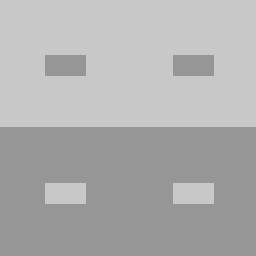

In [ ]:
img_1 = cv2.imread(imagem_zoio)

cv2_imshow(img_1)

In [ ]:
img_1.shape

(256, 256, 3)

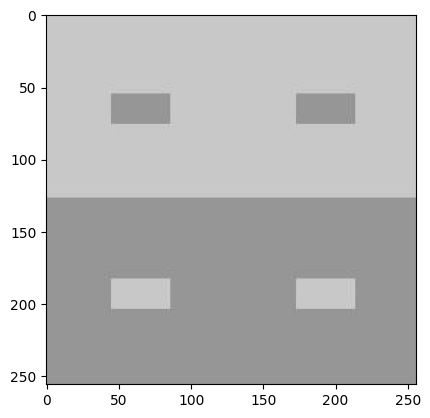

In [ ]:
plt.imshow(img_1)

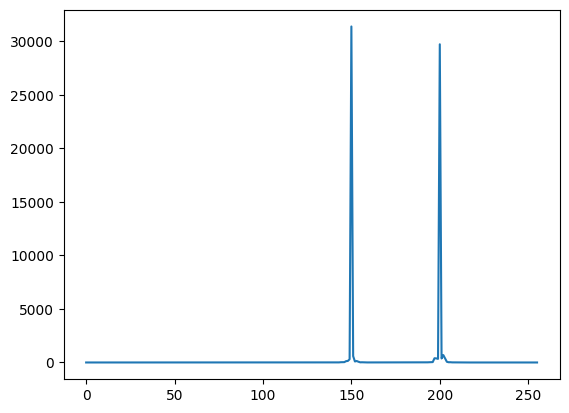

In [ ]:
histogram = cv2.calcHist([img_1], [0], None, [256], [0, 256])

plt.plot(histogram)

#Taxa de Amostragem e Profundidade

In [ ]:
#Encontrando a taxa de amostragem da imagem

img_cinza = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

img_cinza_array = np.array(img_cinza)

sampling_rate = img_cinza_array.shape

print(sampling_rate)

(256, 256)


In [ ]:
img_cinza_array.dtype

dtype('uint8')

#Imagem Binária

In [ ]:
img_1binaria = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

img_1binaria_ = cv2.threshold(img_1binaria, 150, 200, cv2.THRESH_BINARY)[1]

img_1array = np.array(img_1binaria_)

print(img_1array)

[[200 200 200 ... 200 200 200]
 [200 200 200 ... 200 200 200]
 [200 200 200 ... 200 200 200]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
img_1array[img_1array >= 200] = 255
img_1array[img_1array < 200] = 0

print(img_1array)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


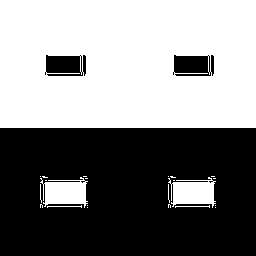

In [ ]:
img_binarizada = img_1array

cv2_imshow(img_binarizada)

In [ ]:
img_binarizada[img_binarizada == 255] = 1
img_binarizada[img_binarizada == 0] = 0

print(img_binarizada)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
def HK_D8(img):
    n_linhas, n_colunas = img.shape #pegando o tamanho da imagem
    rotulos = np.zeros((n_linhas, n_colunas), dtype=int) #criando vetor de zeros p/ atribuir os rotulos
    prox_rot = 1
    igualdade = {}

    #levando a distância D8 como parâmetro
    D8 = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]

    for i in range(n_linhas): #construindo nosso loop para varrer a imagem e estabelecer a rotulagem
        for j in range(n_colunas):
            if img[i, j] == 1:
                vizinhos = []
                for alinhamento in D8:
                    ni, nj = i + alinhamento[0], j + alinhamento[1]
                    if 0 <= ni < n_linhas and 0 <= nj < n_colunas and rotulos[ni, nj] > 0:
                        vizinhos.append(rotulos[ni, nj])

                if not vizinhos:
                    rotulos[i, j] = prox_rot
                    prox_rot += 1
                else:
                    menor_rotulo = min(vizinhos)
                    rotulos[i, j] = menor_rotulo

                    for vizinho in vizinhos:
                        if vizinho != menor_rotulo:
                            if menor_rotulo not in igualdade:
                                igualdade[menor_rotulo] = set()
                            if vizinho not in igualdade:
                                igualdade[vizinho] = set()
                            igualdade[menor_rotulo].add(vizinho)
                            igualdade[vizinho].add(menor_rotulo)

    #equivalências de clusters
    for rotulo, eq_set in igualdade.items():
        min_eq_rotulo = min(eq_set)
        for eq_rotulo in eq_set:
            rotulos[rotulos == eq_rotulo] = min_eq_rotulo

    return rotulos


In [ ]:
print(np.unique(img_binarizada))


[0 1]


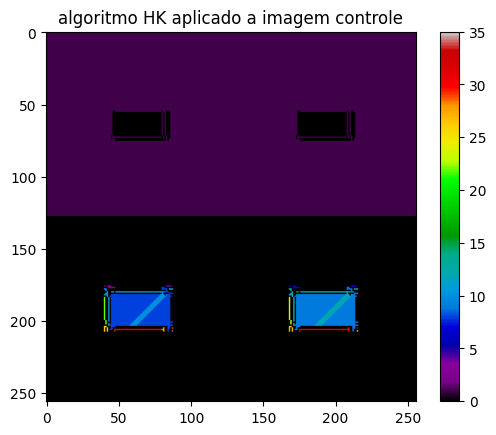

In [ ]:
#Aplicando o algoritmo na imagem binarizada

cluster_img = HK_D8(img_binarizada)

plt.imshow(cluster_img, cmap='nipy_spectral')
plt.colorbar()
plt.title('algoritmo HK aplicado a imagem controle')
plt.show()

In [ ]:
def contar_rotulos(img):
  matriz_rotulos = np.array(img)
  n_rotulos = len(np.unique(matriz_rotulos))
  return n_rotulos

n_rotulos = contar_rotulos(cluster_img)

print('Essa imagem possui', n_rotulos, 'clusters encontrados pelo HK_D8')

Essa imagem possui 28 clusters encontrados pelo HK_D8


In [ ]:
#Contando os componentes conexos dessa imagem

cluster_img_uint8 = cluster_img.astype(np.uint8)

num_rotl, rotl = cv2.connectedComponents(cluster_img_uint8)

print('Essa imagem possui', num_rotl - 1, 'componentes conexos encontrados pelo cv2.connectedComponents')

Essa imagem possui 23 componentes conexos encontrados pelo cv2.connectedComponents


#Calculando as distâncias

In [ ]:
from scipy.spatial import distance

In [ ]:
#calculando a distância euclidiana entre dois componentes conexos

p1 = (50, 200)
p2 = (200,200)

distancia_euclidiana = distance.euclidean(p1, p2)

print(distancia_euclidiana)


150.0


In [ ]:
distancia_chebyshev = distance.chebyshev(p1, p2)

print(distancia_chebyshev)

150


In [ ]:
def distancia_manhattan(p1, p2):
  return np.abs(p2[0] - p1[0]) + np.abs(p2[1] - p1[1])

p1 = (50, 200)
p2 = (200,200)

manhattan = distancia_manhattan(p1, p2)

print(manhattan)

150
